In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
from glob import glob
import tables as tb

In [3]:
gpu = 0

In [4]:
import sys
sys.path.insert(0, 'code')

In [5]:
from v13_deeplab import *

In [6]:
MODEL_NAME = 'v13'
ORIGINAL_SIZE = 650
sz = 256
bs = 1
STRIDE_SZ = 197
PATH = 'data/'

BASE_DIR = "data/train"
BASE_TEST_DIR = "data/test"
WORKING_DIR = "data/working"

# Restore later
IMAGE_DIR = "data/working/images/{}".format('v12')
# IMAGE_DIR = "data/working/images/{}".format('v5')
V5_IMAGE_DIR = "data/working/images/{}".format('v5')

# ---------------------------------------------------------
# Parameters
MIN_POLYGON_AREA = 30  # 30

# ---------------------------------------------------------
# Input files
FMT_TRAIN_SUMMARY_PATH = str(
    Path(BASE_DIR) /
    Path("{prefix:s}_Train/") /
    Path("summaryData/{prefix:s}_Train_Building_Solutions.csv"))
FMT_TRAIN_RGB_IMAGE_PATH = str(
    Path(BASE_DIR) /
    Path("{prefix:s}_Train/") /
    Path("RGB-PanSharpen/RGB-PanSharpen_{image_id:s}.tif"))
FMT_TEST_RGB_IMAGE_PATH = str(
    Path(BASE_TEST_DIR) /
    Path("{prefix:s}_Test/") /
    Path("RGB-PanSharpen/RGB-PanSharpen_{image_id:s}.tif"))
FMT_TRAIN_MSPEC_IMAGE_PATH = str(
    Path(BASE_DIR) /
    Path("{prefix:s}_Train/") /
    Path("MUL-PanSharpen/MUL-PanSharpen_{image_id:s}.tif"))
FMT_TEST_MSPEC_IMAGE_PATH = str(
    Path(BASE_TEST_DIR) /
    Path("{prefix:s}_Test/") /
    Path("MUL-PanSharpen/MUL-PanSharpen_{image_id:s}.tif"))

# ---------------------------------------------------------
# Preprocessing result
FMT_RGB_BANDCUT_TH_PATH = IMAGE_DIR + "/rgb_bandcut.csv"
FMT_MUL_BANDCUT_TH_PATH = IMAGE_DIR + "/mul_bandcut.csv"

# ---------------------------------------------------------
# Image list, Image container and mask container
FMT_VALTRAIN_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_valtrain_ImageId.csv"
FMT_VALTEST_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_valtest_ImageId.csv"
FMT_VALTRAIN_IM_STORE = IMAGE_DIR + "/valtrain_{}_im.h5"
FMT_VALTEST_IM_STORE = IMAGE_DIR + "/valtest_{}_im.h5"
FMT_VALTRAIN_MASK_STORE = IMAGE_DIR + "/valtrain_{}_mask.h5"
FMT_VALTEST_MASK_STORE = IMAGE_DIR + "/valtest_{}_mask.h5"
FMT_VALTRAIN_MUL_STORE = IMAGE_DIR + "/valtrain_{}_mul.h5"
FMT_VALTEST_MUL_STORE = IMAGE_DIR + "/valtest_{}_mul.h5"

FMT_TRAIN_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_train_ImageId.csv"
FMT_TEST_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_test_ImageId.csv"
FMT_TRAIN_IM_STORE = IMAGE_DIR + "/train_{}_im.h5"
FMT_TEST_IM_STORE = IMAGE_DIR + "/test_{}_im.h5"
FMT_TRAIN_MASK_STORE = IMAGE_DIR + "/train_{}_mask.h5"
FMT_TRAIN_MUL_STORE = IMAGE_DIR + "/train_{}_mul.h5"
FMT_TEST_MUL_STORE = IMAGE_DIR + "/test_{}_mul.h5"
FMT_MULMEAN = IMAGE_DIR + "/{}_mulmean.h5"

# ---------------------------------------------------------
# Model files
MODEL_DIR = "data/working/models/{}".format(MODEL_NAME)
FMT_VALMODEL_PATH = MODEL_DIR + "/{}_val_weights.h5"
FMT_FULLMODEL_PATH = MODEL_DIR + "/{}_full_weights.h5"
FMT_VALMODEL_HIST = MODEL_DIR + "/{}_val_hist.csv"
FMT_VALMODEL_EVALHIST = MODEL_DIR + "/{}_val_evalhist.csv"
FMT_VALMODEL_EVALTHHIST = MODEL_DIR + "/{}_val_evalhist_th.csv"

# ---------------------------------------------------------
# Prediction & polygon result
FMT_TESTPRED_PATH = MODEL_DIR + "/{}_pred.h5"
FMT_VALTESTPRED_PATH = MODEL_DIR + "/{}_eval_pred.h5"
FMT_VALTESTPOLY_PATH = MODEL_DIR + "/{}_eval_poly.csv"
FMT_VALTESTTRUTH_PATH = MODEL_DIR + "/{}_eval_poly_truth.csv"
FMT_VALTESTPOLY_OVALL_PATH = MODEL_DIR + "/eval_poly.csv"
FMT_VALTESTTRUTH_OVALL_PATH = MODEL_DIR + "/eval_poly_truth.csv"
FMT_TESTPOLY_PATH = MODEL_DIR + "/{}_poly.csv"
FN_SOLUTION_CSV = "data/output/{}.csv".format(MODEL_NAME)

# ---------------------------------------------------------
# Model related files (others)
FMT_VALMODEL_LAST_PATH = MODEL_DIR + "/{}_val_weights_last.h5"
FMT_FULLMODEL_LAST_PATH = MODEL_DIR + "/{}_full_weights_last.h5"

## Preprocessing

In [7]:
# for train_path in ['data/train/AOI_2_Vegas_Train', 'data/train/AOI_3_Paris_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']:
#     !python code/v5_im.py preproc_train {train_path}

In [8]:
# for train_path in ['data/train/AOI_2_Vegas_Train', 'data/train/AOI_3_Paris_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']:
#     !python code/v12_im_deeplab.py preproc_train {train_path}

### Overload

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [10]:
# memory dataset
def get_dataset(datapath):
    area_id = directory_name_to_area_id(datapath)
    prefix = area_id_to_prefix(area_id)
    trn_x, trn_y = get_valtrain_data(area_id)
    val_x, val_y = get_valtest_data(area_id)
    
    trn_x = trn_x[:,:3]; trn_x = np.moveaxis(trn_x, 1, -1).astype('float')
    trn_y = trn_y[:,:3]; trn_y = np.moveaxis(trn_y, 1, -1).astype('float')
    trn_y = np.broadcast_to(trn_y, (trn_y.shape[0], 256, 256, 3))
    
    val_x = val_x[:,:3]; val_x = np.moveaxis(val_x, 1, -1).astype('float')
    val_y = val_y[:,:3]; val_y = np.moveaxis(val_y, 1, -1).astype('float')
    val_y = np.broadcast_to(val_y, (val_y.shape[0], 256, 256, 3))
    return (trn_x,trn_y), (val_x,val_y)


In [11]:
# class H5Dataset(BaseDataset):
#     def __init__(self, fnames, transform, path):
#         self.path,self.fnames = path,fnames
#         super().__init__(transform)
#     def get_sz(self): return self.transform.sz
#     def get_x(self, i): 
#         return open_image(os.path.join(self.path, self.fnames[i]))
#     def get_n(self): return len(self.fnames)

#     def resize_imgs(self, targ, new_path):
#         dest = resize_imgs(self.fnames, targ, self.path, new_path)
#         return self.__class__(self.fnames, self.y, self.transform, dest)

#     def denorm(self,arr):
#         """Reverse the normalization done to a batch of images.

#         Arguments:
#             arr: of shape/size (N,3,sz,sz)
#         """
#         if type(arr) is not np.ndarray: arr = to_np(arr)
#         if len(arr.shape)==3: arr = arr[None]
#         return self.transform.denorm(np.rollaxis(arr,1,4))


In [12]:
# rgb scaled
def get_rgb_scaled(datapath):
    area_id = directory_name_to_area_id(datapath)
    prefix = area_id_to_prefix(area_id)
    
    X_val = []
    fn_im = FMT_VALTEST_IM_STORE.format(prefix)
    with tb.open_file(fn_im, 'r') as f:
        for idx, image_id in enumerate(df_test.ImageId.tolist()):
            im = np.array(f.get_node('/' + image_id))
            im = np.swapaxes(im, 0, 2)
            im = np.swapaxes(im, 1, 2)
            X_val.append(im)
    X_val = np.array(X_val)

    y_val = []
    fn_mask = FMT_VALTEST_MASK_STORE.format(prefix)
    with tb.open_file(fn_mask, 'r') as f:
        for idx, image_id in enumerate(df_test.ImageId.tolist()):
            mask = np.array(f.get_node('/' + image_id))
            mask = (mask > 0.5).astype(np.uint8)
            y_val.append(mask)
    y_val = np.array(y_val)
    y_val = y_val.reshape((-1, 1, INPUT_SIZE, INPUT_SIZE))
    
    

    return X_val, y_val

In [13]:
datapath = 'data/train/AOI_3_Paris_Train'

In [14]:
(trn_x,trn_y), (val_x,val_y) = get_dataset(datapath)

In [15]:
x, y = next(zip(trn_x, trn_y))
print(x.shape, y.shape)

(256, 256, 3) (256, 256, 3)


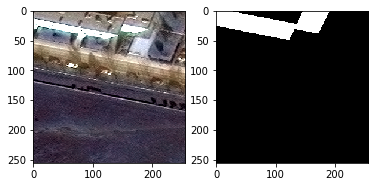

In [16]:
plt.subplot(121)
plt.imshow(x)
plt.subplot(122)
plt.imshow(y)

In [17]:
class ArraysSingleDataset(ArraysDataset):
    def get_c(self): return 1
    def denorm(self, arr):
        """Reverse the normalization done to a batch of images.

        Arguments:
            arr: of shape/size (N,3,sz,sz)
        """
        if type(arr) is not np.ndarray: arr = to_np(arr)
        if len(arr.shape)==3: arr = arr[None]
        return np.clip(self.transform.denorm(np.rollaxis(arr,1,4)), 0, 1)

In [18]:
sys.path.insert(0, 'deeplab/pytorch-deeplab-resnet')
import deeplab_resnet

In [19]:
class Deeplab():
    def __init__(self,model,name='deeplab'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        c = list(children(self.model))
        return [c]

In [20]:
def get_deeplab(NoLabels=1):
    model = deeplab_resnet.Res_Deeplab(NoLabels)

    saved_state_dict = torch.load('deeplab/pytorch-deeplab-resnet/data/MS_DeepLab_resnet_trained_VOC.pth')
    if NoLabels != 21:
        for i in saved_state_dict:
            #Scale.layer5.conv2d_list.3.weight
            i_parts = i.split('.')
            if i_parts[1]=='layer5':
                saved_state_dict[i] = model.state_dict()[i]

    model.load_state_dict(saved_state_dict)
    model.float()
    model.eval() # use_global_stats = True
    return Deeplab(model)
#     return model

In [21]:
# def jaccard_coef(y_true, y_pred):
#     smooth = 1e-12
#     intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
#     sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
#     jac = (intersection + smooth) / (sum_ - intersection + smooth)
#     return K.mean(jac)


# def jaccard_coef_int(y_true, y_pred):
#     smooth = 1e-12
#     y_pred_pos = K.round(K.clip(y_pred, 0, 1))
#     intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
#     sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])
#     jac = (intersection + smooth) / (sum_ - intersection + smooth)
#     return K.mean(jac)

In [22]:
from torch import Tensor
def jaccard_coef(y_true, y_pred):
    smooth = 1e-12
    intersection = Tensor.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = Tensor.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return Tensor.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    smooth = 1e-12
    y_pred_pos = Tensor.round(K.clip(y_pred, 0, 1))
    intersection = Tensor.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = Tensor.sum(y_true + y_pred_pos, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return Tensor.mean(jac)

In [23]:
aug_tfms = [RandomRotateZoom(9, 0.18, 0.1, tfm_y=TfmType.CLASS), RandomLighting(0.05, 0.1, tfm_y=TfmType.CLASS), RandomDihedral(tfm_y=TfmType.CLASS)]

# aug_tfms=transforms_top_down

In [24]:
def get_md_model(datapath):
    area_id = directory_name_to_area_id(datapath)
    prefix = area_id_to_prefix(area_id)
#     tfms = tfms_from_model(resnet101, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    tfms = tfms_from_model(resnet101, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=RandomRotateZoom(9, 0.18, 0.1, tfm_y=TfmType.CLASS))
    datasets = ImageData.get_ds(ArraysSingleDataset, (trn_x,trn_y), (val_x,val_y), tfms)
    md = ImageData('data', datasets, bs, num_workers=8, classes=None)
    denorm = md.trn_ds.denorm

    if not Path(MODEL_DIR).exists():
        Path(MODEL_DIR).mkdir(parents=True)

    logger.info("Instantiate deeplab model")
    model = get_deeplab()
    model.model = model.model.cuda(gpu)
    return md, model, denorm

In [25]:
md, model, denorm = get_md_model(datapath)

In [26]:
learn = ConvLearner(md, model)
learn.opt_fn=optim.Adam
learn.crit=F.binary_cross_entropy_with_logits
learn.metrics=[jaccard_coef, jaccard_coef_int]

In [27]:
def data_parallel(module, input, device_ids, output_device=None):
    if not device_ids:
        return module(input)

    if output_device is None:
        output_device = device_ids[0]

    replicas = nn.parallel.replicate(module, device_ids)
    inputs = nn.parallel.scatter(input, device_ids)
    replicas = replicas[:len(inputs)]
    outputs = nn.parallel.parallel_apply(replicas, inputs)
    return nn.parallel.gather(outputs, output_device)

In [28]:
x, y = md.trn_dl.get_batch([0])

In [29]:
x.shape, y.shape

((1, 3, 256, 256), (1, 256, 256))

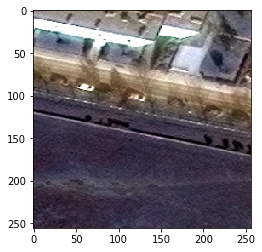

In [30]:
plt.imshow(denorm(x)[0])

In [31]:
np.min(denorm(x)[0])

0.0

In [33]:
output = model.model(Variable(torch.FloatTensor(np.broadcast_to(x, [5,3,256,256])).cuda(gpu)))
print(output.shape)

# output = np.argmax(output,axis = 2)

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

In [ ]:
print(output.shape)

In [ ]:
to_np(output)[0].squeeze()

In [ ]:
plt.imshow(to_np(output)[0].squeeze())

In [ ]:
learn.lr_find()
learn.sched.plot()